In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

import imagepers

from skimage.filters import threshold_otsu, median, threshold_multiotsu
from scipy.signal import peak_widths, find_peaks, peak_prominences
from scipy.ndimage import shift
from scipy.optimize import curve_fit
from scipy import interpolate

# https://www.sthu.org/code/codesnippets/imagepers.html

# !!! подразумевается, что изначальное изображение квадратное

In [ ]:
# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(im)

# %matplotlib notebook
# ax = fig.add_subplot(1, 2, 2, projection='3d')
# xx, yy = np.mgrid[0:im.shape[0], 0:im.shape[1]]
# ax.plot_surface(xx, yy, im, rstride=10, cstride=10)
# plt.show()

In [2]:
def myPEAKS(im, accuracy=None, draw_output=None):
    '''
    Функция для поиска пиков в 2d массиве. Изображение на вход лучше подавать "очищенным"
    
    im - 2d array, изображение
    accuracy - точность разделения пиков
    '''
    g0 = imagepers.persistence(im)
#     print(g0)
    x_coord, y_coord = [], []

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax.set_title("Peristence diagram")
    ax.plot([0,255], [0,255], c='grey')
    for i, homclass in enumerate(g0):
        p_birth, bl, pers, p_death = homclass
#         print(f'p_birth: {p_birth}, bl (birth lvl): {bl}, pers: {pers}, death lvl: {bl-pers}, p_death: {p_death}')
        if pers <= accuracy:
            continue

        x, y = bl, bl-pers
        ax.scatter(x, y, s=5)
        ax.text(x, y+2, str(i+1))
    ax.set_xlabel("Birth level, indicates the maximum distance between adjacent peaks")
    ax.set_ylabel("Death level, indicates the size of the peak")


    ax2.set_title("Loci of births")
    for i, homclass in enumerate(g0):
        p_birth, bl, pers, p_death = homclass
        if pers <= accuracy:
            continue

        y, x = p_birth

        x_coord.append(x)
        y_coord.append(y)
        ax2.scatter(x, y, s=5)
        ax2.imshow(im)
        ax2.text(x, y+1, str(i+1))

    converated_peaks = [(y_coord[i] * im.shape[0]) + x_coord[i] for i in range(len(y_coord))] # перевод 2d координат пиков в 1d 
    converated_peaks = np.sort(converated_peaks)
    return [x_coord, y_coord], converated_peaks

def func1(im, accuracy=None):
    '''
    Функция поиска всех пиков на изображении. Возвращает координаты и значения пиков в развернутом 1d изображении.
    
    Если расстояние между соседними пиками в развернутом 1d массиве больше, чем размер изначального изображения,
    то между этими соседними точками добавляются нулевые-точки-значения.
    
    Эта функция полезна для последующей интерполяции, так как она позволяет разделить изначальную группу пиков в 1d массиве
    на несколько взависимости от изначального расстояния между этими пиками
    
    im - 2d изображение;
    accuracy - точность определения границы, при которой добавляются нулевые значения;
    '''
    peak_coord, peak_value = find_peaks(im, height=0)
    peak_value = np.array(list(peak_value.items())[0][1])
    border_value = accuracy
    if np.any(np.where(np.diff(peak_coord) > border_value)[0]):
        border = np.where(np.diff(peak_coord) > border_value)[0][0]
        arr2 = [peak_coord[border] + (i+1)*border_value for i in range(np.diff(peak_coord)[border]//border_value)]
        new_peak_coord = np.concatenate([peak_coord[0:border+1], arr2, peak_coord[border+1:]], axis=0)
        new_peak_value = np.concatenate([peak_value[0:border+1], np.zeros_like((arr2,))[0], peak_value[border+1:]], axis=0)

    else:
        new_peak_coord = peak_coord
        new_peak_value = peak_value
    return new_peak_coord, new_peak_value

def func2(peak_coord, peak_value, kind="linear"):
    '''
    Функция интерполяции по точкам найденных пиков. 
    
    peak_coord - координаты пиков
    peak_value - значения пиков
    kind - тип интерполяции
    '''
    x = np.linspace(peak_coord[0], peak_coord[-1], peak_coord[-1]-peak_coord[0])
    interp = interpolate.interp1d(peak_coord, peak_value, kind=kind) 
    y_nearest = interp(x)
    y2 = np.pad(y_nearest, (peak_coord[0], len(im.ravel())-peak_coord[-1]), 'constant', constant_values=(0))
    return y2

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def func3(values2, converated_peaks):
    '''
    Функция сопоставления изначальных пиков с пиками, полученными после интерполяции. Так как ширину можно узнать только
    у интерполированного пика (потому что он закреплен на графике), то нужно сопоставить этот пик с реальным,
    чтобы соотнести ширину этого пика с реальным.
    
    values2 - интерполированные пики
    converated_peaks - исходные пики
    '''
    peak_coord, peak_value = find_peaks(values2, height=0)
    peak_value = np.array(list(peak_value.items())[0][1])

    prominences = peak_prominences(values2, peak_coord)[0]
    contour_heights = values2[peak_coord] - prominences
    results_half = peak_widths(values2, peak_coord, rel_height=0.5, prominence_data=peak_prominences(values2, peak_coord))
    width=[]
    for i in range(len(converated_peaks)):
        idx = find_nearest(peak_coord, converated_peaks[i])
        width.append(peak_widths(values2, [peak_coord[idx]], rel_height=0.5, 
                                         prominence_data=peak_prominences(values2, [peak_coord[idx]]))[0][0])

    info = [peak_coord, contour_heights, results_half, peak_value]
    return width, info

def myWIDTH(im, converated_peaks, draw_output=None):
    peaks, values = func1(im.ravel(), accuracy=im.shape[0]+5)
    if len(peaks) == 1:
        print('!WARNING: only one peak detected, plotting impossible\n')
        width = peak_widths(im.ravel(), [converated_peaks][0], rel_height=0.5)[0]
        
    else:
        peaks, values = func1(im.ravel(), accuracy=im.shape[0]+5) # ищем изначальные пики
        values2 = func2(peaks, values) # интерполируем найденные пики
        width, info = func3(values2, converated_peaks) # ищем новые пики после интерполяции и далее определяем их ширину
    print('peaks:')
    for i in range(len(converated_peaks)):
        print('1d:', converated_peaks[i], '|', '2d:', np.unravel_index(converated_peaks[i], im.shape), '|', 'width:', width[i])
    #-------------------------------
    if draw_output == 'yes' and len(peaks) != 1:
        plt.figure()
        plt.plot(im.ravel(), c='gray', ls='--', alpha=0.5, label='изначальное 1d изображение')
        plt.plot(values2, c='black', alpha=0.5, label='интерполяция')
        plt.scatter(converated_peaks, values2[converated_peaks], c='red', marker='x', label='целевые пики')
        plt.scatter(info[0], info[3], c='black', alpha=0.5, marker='o', label='пики после интерполяции')
        results_half = info[2]
        plt.hlines(*results_half[1:], color="C4", label='полуширина')
        plt.vlines(x=info[0], ymin=info[1], ymax=values2[info[0]], color='C2', label='высота')
        plt.legend(loc='upper left', fontsize='xx-small', bbox_to_anchor=(1.05, 1.0))
        plt.xlim(peaks[0]-2000, peaks[-1]+2000)
        plt.show()
    
    return np.unravel_index(converated_peaks, im.shape), width

peaks:
1d: 102378 | 2d: (226, 226) | width: 1557.7345377353486
1d: 105976 | 2d: (234, 208) | width: 2956.8986195412144
1d: 111848 | 2d: (247, 204) | width: 3257.0647255717777
1d: 119514 | 2d: (264, 186) | width: 2408.306674016392
1d: 127181 | 2d: (281, 169) | width: 7054.797872311421
 
Vx: 0.00, Vy: 0.00, Cn2: 1.51*1e-13, z: 2020.20
Vx: -4.98, Vy: -2.21, Cn2: 0.44*1e-13, z: 10101.01
Vx: -6.08, Vy: -5.81, Cn2: 0.33*1e-13, z: 12121.21
Vx: -11.06, Vy: -10.51, Cn2: 0.64*1e-13, z: 6060.61
Vx: -15.76, Vy: -15.21, Cn2: 0.24*1e-13, z: 49494.95

total Cn2: 3.1614637827543565e-13
r0: 2.54
seeing: 0.40

[[0.0, 0.0, 1.513028296385884, 2020.20202020202], [-4.977876106194691, -2.2123893805309733, 0.4392123485703947, 10101.0101010101], [-6.084070796460177, -5.807522123893805, 0.3285421648384821, 12121.21212121212], [-11.061946902654867, -10.508849557522124, 0.6440123203081816, 6060.60606060606], [-15.763274336283187, -15.210176991150442, 0.23666865265141396, 49494.94949494949]]


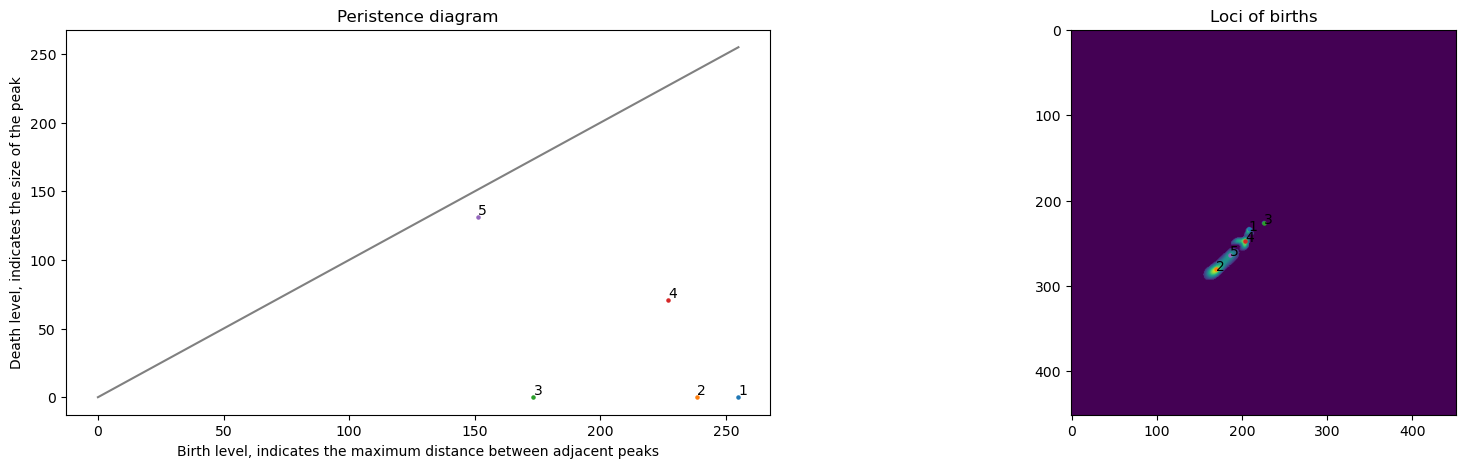

In [13]:
img = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")
D=2.5  # pupil diametr
spf=0.01  # sec per frame
latency=4  # cross corr latency
delta = D/(img.shape[0]//2)
t = spf * latency

a1 = np.loadtxt(f'D:/astro/domecam/z.gz') # распределение гамм по высотам
a2 = np.loadtxt(f'D:/astro/domecam/z_width.gz') # ширина гамм, соответствующая распределениям по высотам
# для того чтобы найти приближенное значение по высоте, нужно индекс ширины из a2 подставить в a1

cjk = np.loadtxt(f'D:/astro/domecam/cjk.gz')
gammas = np.load("D:/astro/domecam/gammas_orig.npy")

im = img.copy()
im = im*(im > threshold_multiotsu(im)[0])
im = median(im)
im = im*(255 / np.max(im))
_, coords1d = myPEAKS(im, accuracy=20, draw_output='no')
coords2d, widths = myWIDTH(im, coords1d, draw_output='no')

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

print(' ')
total_Cn2=[]
initial_params=[]
for i in range(len(widths)):
    Vy = (img.shape[0]//2-coords2d[0][i])*delta/t
    Vx = -(img.shape[1]//2-coords2d[1][i])*delta/t
    idx = find_nearest(a2, widths[i])
    Cn2 = (img[coords2d[0][i], coords2d[1][i]] \
           / (cjk[coords2d[0][i], coords2d[1][i]] * np.max(gammas[idx])))
    
    total_Cn2.append(Cn2)
    layer = [Vx, Vy, Cn2, a1[idx]]
    initial_params.append(layer)
    print(f'Vx: {Vx:.2f}, Vy: {Vy:.2f}, Cn2: {Cn2:.2f}*1e-13, z: {a1[idx]:.2f}')
    

r0 = pow(0.423 * pow((2*np.pi/(500*10e-9)), 2) * (np.sum(total_Cn2)*1e-13), -3/5)
seeing = 206265 * 0.98 * 500*10e-9/r0

print('\ntotal Cn2:', np.sum(total_Cn2)*1e-13)
print(f'r0: {r0:.2f}')
print(f'seeing: {seeing:.2f}')


In [14]:
def find_nearest1(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] >= value: #поставил тут =
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx
        
def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    Cn2=Cn2*1e-13
    z=z*1000
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest1(a1, z)[1]
    uv = find_nearest1(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    
    res = shift(res, (-Ypix, Xpix), order=2)  

    res = res * cjk
    return res

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

Time: 90.8682
0.004006965658725578 0.042703708117727654 1.110887541207597 2.2677445188341863
-6.356299889305033 -5.807526419815169 0.11647975728138804 37.46962264608016
-9.801279051321153 -9.675904974188716 0.0425519107354094 84.05639274625054
-13.21949016946617 -12.958463011614759 0.13717783079417076 52.59616865369183
-16.421020229759023 -15.767348164380776 0.2792636839066385 43.03343345936588


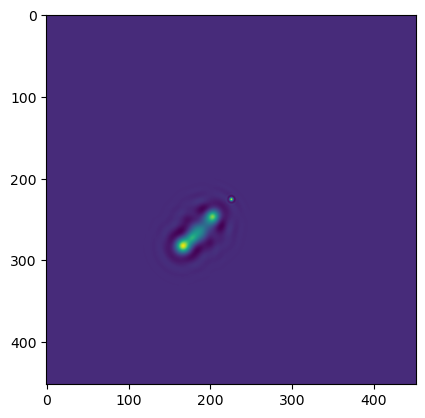

In [16]:
fit, popt = one_speckle_fit(params=initial_params, data=img)
plt.imshow(fit)